In [1]:
import uproot
uproot.__version__

'4.3.7'

In [69]:
import json
import pyhf
pyhf.set_backend('numpy')
from pyhf.contrib.viz import brazil

In [3]:
import cabinetry

In [4]:
import uproot # was '4.3.7'
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
# import vector
from tqdm import tqdm
import time
import glob
import pickle
import os

_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
mc20 = "mc20e"   
data = "2018"

In [6]:
directory = "limits_Jun16/"
path = "./"+directory+data
isExist = os.path.exists(directory)


if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(directory)
isExist = os.path.exists(path)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)
    print("The new directory is created!")

In [91]:
bins = np.linspace(2000,4000,51)
sigma = 1

## Signal

In [7]:
signalDir = "/data/rainbolt/sh4b/sh4b_selection/signal"

In [8]:
if (data == "2018"):
    # mask_2b1j  = tree['HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'] == True #mc20e (2018)
    # mask_lrj_1 = tree['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] == True
    lumi_b = 58.0339 #mc20e (2018)
    lumi_nonb = 58.7916 #mc20e (2018)
elif (data == "2017"):
    # mask_2b1j  = tree['HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30'] == True #mc20d (2017)
    # mask_lrj_1 = tree['HLT_j420_a10t_lcw_jes_40smcINF_L1J100'] == True  
    lumi_b = 43.9668 #mc20d (2017)
    lumi_nonb = 44.6306 #mc20d (2017)
elif (data == "2016"):    
    # mask_2b1j  = tree['HLT_j100_2j55_bmv2c2060_split'] == True #mc20d (2016)
    # mask_lrj_1 = tree['HLT_j420_a10_lcw_L1J100'] == True
    lumi_b = 24.8658 #mc20a (2016)
    lumi_nonb = 33.4022 #mc20a (2016)

In [42]:
columns_to_load = [
    "n_gen_events",
    "HLT_j420_a10t_lcw_jes_35smcINF_L1J100",
    "X_mass",
    "S_mass",
    "H_mass"
]

truth_X = []
truth_S = []

dfs = {}
sig_hists = {}
    

filenames = glob.glob(signalDir + '/mc20e*.root') # list   
for filename in filenames:
    
    X = filename.split('mX')[1].split('_mS')[0]
    S = filename.split('mS')[1].split('_btag')[0]  
    X = int(X)
    S = int(S)
    
    df = None 
#     tree = uproot.open(f)[tree_name]
# arr = tree.arrays(vars_to_save)
# df_uproot = pd.DataFrame(arr)[vars_to_save]

    tree = uproot.open(filename + ':trees')
    sig_tree = tree['mixed_pass_signal']
    df_yr = sig_tree.arrays(columns_to_load, library="pd")
    # print(df_yr["mc_sf"])

    # apply analysis cuts
    # df_yr["X_SH"] = np.sqrt(((df_yr["m_H"] - 125) / (.1 * df_yr["m_H"])) ** 2 + ((df_yr["m_S"] - ms) / (.1 * df_yr["m_S"])) ** 2)
    
    trigger_mask = (df_yr['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] == True)

    df_yr = df_yr.loc[trigger_mask]

    if df is None:
        df = df_yr
    else:
        df = pd.concat([df, df_yr], ignore_index=True)


    if X<750:continue
    truth_X.append(X)
    truth_S.append(S)

    dfs[f"{X}_{S}"] = df
    # bins = np.linspace(250,8000,100)
    # bins = np.linspace(1000,3500,10)
    
    sig_hists[f"{X}_{S}"] = np.histogram(df["X_mass"], bins=bins, weights=(lumi_nonb * sigma)/df["n_gen_events"])
    # sig_hists[f"{X}_{S}"] = np.histogram(df["X_mass"], bins=bins, weights=1)[0]

    # print(f"{X}_{S}")
    # plt.hist(df["X_mass"], bins=bins, weights=1/df["n_gen_events"])[0]
    # plt.show()

    
# Remove duplicates
truth_X = list(set(truth_X))
truth_S = list(set(truth_S))

# Sort in ascending order
truth_X.sort()
truth_S.sort()

print(truth_X)
print(truth_S)

[750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
[70, 100, 170, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]


## Backround

In [43]:
if (data == "2016"):
    data_trees = uproot.open('/data/rainbolt/sh4b/sh4b_selection/background/data16_btag77_xbbtag70.root:trees')
elif(data == "2017"):
    data_trees = uproot.open('/data/rainbolt/sh4b/sh4b_selection/background/data17_btag77_xbbtag70.root:trees')
elif (data == "2018"):
    data_trees = uproot.open('/data/rainbolt/sh4b/sh4b_selection/background/data18_btag77_xbbtag70.root:trees')

In [44]:
pass_VRL = data_trees['mixed_pass_validation_low'].arrays()
pass_CRL = data_trees['mixed_pass_control_low'].arrays()
# SR       = data_trees['mixed_pass_signal'] # This should be blinded
pass_CRH = data_trees['mixed_pass_control_high'].arrays()
pass_VRH = data_trees['mixed_pass_validation_high'].arrays()

fail_VRL = data_trees['mixed_failxbb_validation_low'].arrays()
fail_CRL = data_trees['mixed_failxbb_control_low'].arrays()
fail_CR0 = data_trees['mixed_failxbb_signal'].arrays()
fail_CRH = data_trees['mixed_failxbb_control_high'].arrays()
fail_VRH = data_trees['mixed_failxbb_validation_high'].arrays()

fail2b_VRL = data_trees['mixed_fail2b_validation_low'].arrays()
fail2b_CRL = data_trees['mixed_fail2b_control_low'].arrays()
fail2b_CR0 = data_trees['mixed_fail2b_signal'].arrays()
fail2b_CRH = data_trees['mixed_fail2b_control_high'].arrays()
fail2b_VRH = data_trees['mixed_fail2b_validation_high'].arrays()


In [45]:
TF_high  = len(pass_CRH)/len(fail_CRH)
TF_low   = len(pass_CRL)/len(fail_CRL)
TF_total = (len(pass_CRH) + len(pass_CRL))/(len(fail_CRH) + len(fail_CRH))
TF_mean  = (TF_high + TF_low)/2
print ("Transfer factor high  : ", TF_high)
print ("Transfer factor low   : ", TF_low)
print ("Transfer factor total : ", TF_total)
print ("Transfer factor mean  : ", TF_mean)

Transfer factor high  :  0.01661519214981039
Transfer factor low   :  0.012886405959031658
Transfer factor total :  0.01507095664412213
Transfer factor mean  :  0.014750799054421025


In [46]:
fail_CR0["X_mass"]

<Array [690, 868, ... 1.23e+03, 1.1e+03] type='32296 * float32'>

In [47]:
w = [TF_total] * len(fail_CR0["X_mass"])
bkg_hist = np.histogram(fail_CR0["X_mass"], bins=bins, weights=np.array(w))#, weights=[TF_total]*len(fail_CR0["X_mass"]))

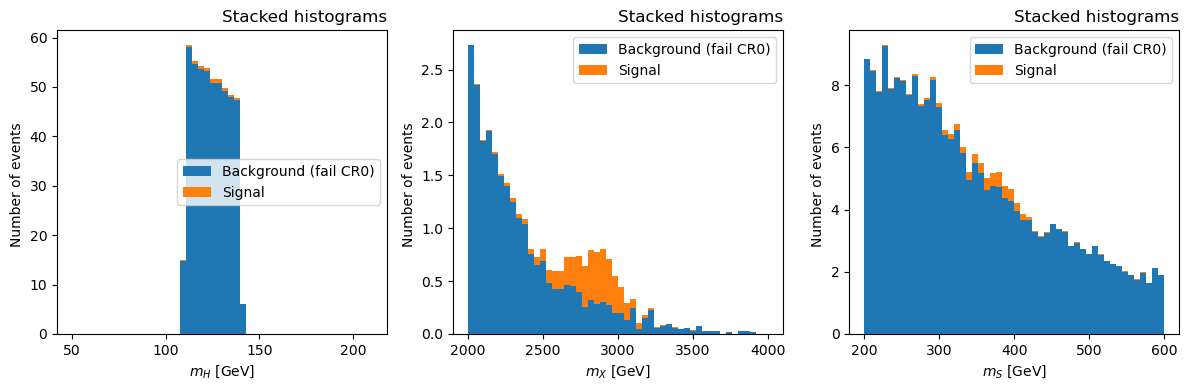

In [48]:
X = 3000
S = 400
sigma = 1

data_h = [
    fail_CR0["H_mass"],
    dfs[f'{X}_{S}']["H_mass"]
]
data_x = [
    fail_CR0["X_mass"],
    dfs[f'{X}_{S}']["X_mass"]
]
data_s = [
    fail_CR0["S_mass"],
    dfs[f'{X}_{S}']["S_mass"]
]

weights = [
    [TF_total] * len(data_h[0]),
    lumi_nonb * sigma / dfs[f'{X}_{S}']['n_gen_events'].values
]
labels = [
    'Background (fail CR0)',
    'Signal'
]

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

ax[0].hist(data_h, weights=weights, label=labels, stacked=True, bins=50, range=(50, 210))
ax[1].hist(data_x, weights=weights, label=labels, stacked=True, bins=50, range=(2000, 4000))
ax[2].hist(data_s, weights=weights, label=labels, stacked=True, bins=50, range=(200, 600))

ax[0].set_xlabel('$m_{H}$ [GeV]')
ax[1].set_xlabel('$m_{X}$ [GeV]')
ax[2].set_xlabel('$m_{S}$ [GeV]')

for a in ax:
    a.legend()
    a.set_title('Stacked histograms', loc='right')
    a.set_ylabel('Number of events ')
# plt.savefig(path +"/"+  "mH_CR0" + '.pdf')
plt.tight_layout()
plt.show()

## Plot from np histograms

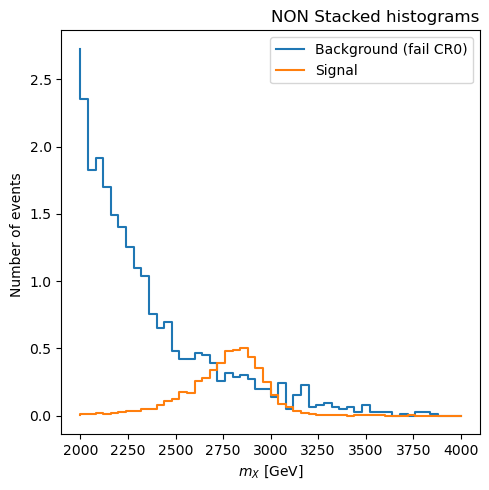

In [50]:
sigma = 1

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))

bins = bkg_hist[1]
histo = bkg_hist[0]
histo = np.append(histo, histo[-1])
plt.step(bins, histo, label='Background (fail CR0)')

bins = sig_hists[f"{X}_{S}"][1]
histo = sig_hists[f"{X}_{S}"][0]
histo = np.append(histo, histo[-1])
plt.step(bins, histo, label='Signal')

ax.set_xlabel('$m_{X}$ [GeV]')

for a in [ax]:
    a.legend()
    a.set_title('NON Stacked histograms', loc='right')
    a.set_ylabel('Number of events ')
# plt.savefig(path +"/"+  "mH_CR0" + '.pdf')
plt.tight_layout()
plt.show()

In [72]:
X = 3000
S = 400

workspace_def = {
    "channels": [
        { "name": "singlechannel",
          "samples": [
              { "name": "signal",
                "data": sig_hists[f"{X}_{S}"][0].tolist(),
                "modifiers": [
                    {"name": "mu", "type": "normfactor", "data": None}
                ],
              },
              { "name": "background",
                "data": bkg_hist[0].tolist(),
                "modifiers": [
                    { "name": "uncorr_bkguncrt",
                      "type": "shapesys",
                      "data": np.sqrt(bkg_hist[0]).tolist(),
                    }
                ],
              }
           ]
        }
    ],
    "measurements": [
        { "config": {"parameters": [], "poi": "mu" },
          "name": "cat_limits"
        }
    ],
    "observations": [
        { "name": "singlechannel",
          "data": bkg_hist[0].tolist()},
    ],
    "version": "1.0.0"
}



In [93]:
workspace = pyhf.Workspace(workspace_def)

model = workspace.model()

# print(json.dumps(model.spec, indent=2))

In [94]:
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"  nauxdata: {model.config.nauxdata}")
print(f"   auxdata: {model.config.auxdata}")

  channels: ['singlechannel']
     nbins: {'singlechannel': 50}
   samples: ['background', 'signal']
 modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]
parameters: ['mu', 'uncorr_bkguncrt']
  nauxdata: 50
   auxdata: [2.727843152588946, 2.3510692364855004, 1.8235857539406766, 1.9140114938055035, 1.7030181007875742, 1.4920247077696445, 1.4015989679048173, 1.250889401463439, 1.1001798350220613, 1.0398960084455098, 0.7535478322068911, 0.6480511356979263, 0.6932640056303399, 0.4822706126124104, 0.4219867860358591, 0.4219867860358591, 0.4671996559682725, 0.45212869932413463, 0.39184487274758334, 0.256206262950343, 0.3164900895268943, 0.2863481762386186, 0.30141913288275646, 0.27127721959448076, 0.1959224363737917, 0.1959224363737917, 0.1356386097972404, 0.24113530630620517, 0.04521286993241347, 0.15070956644137826, 0.22606434966206734, 0.06028382657655129, 0.07535478322068911, 0.09042573986482692, 0.06028382657655129, 0.04521286993241347, 0.06028382657655129, 0.030141913288

In [95]:
model.expected_data([1]*51, include_auxdata=False)

array([2.73372231e+00, 2.36380742e+00, 1.83632393e+00, 1.92968925e+00,
       1.71575628e+00, 1.51456149e+00, 1.42609547e+00, 1.28420464e+00,
       1.13447494e+00, 1.08986887e+00, 8.05480412e-01, 7.29379516e-01,
       8.03988186e-01, 6.02793393e-01, 5.94442146e-01, 5.90522706e-01,
       7.26862556e-01, 7.28449219e-01, 7.33816013e-01, 6.44230823e-01,
       7.93681910e-01, 7.76278176e-01, 8.00167873e-01, 7.07314920e-01,
       5.46712316e-01, 4.45786736e-01, 2.88496770e-01, 3.28342846e-01,
       1.05964190e-01, 1.82065086e-01, 2.42721970e-01, 6.91025666e-02,
       8.31936632e-02, 9.23854599e-02, 6.12636866e-02, 4.71725899e-02,
       6.02838266e-02, 3.30814933e-02, 7.82943632e-02, 3.11217733e-02,
       3.21016333e-02, 3.01419133e-02, 0.00000000e+00, 1.50709566e-02,
       9.79860000e-04, 3.01419133e-02, 3.01419133e-02, 1.50709566e-02,
       0.00000000e+00, 0.00000000e+00])

In [106]:
n_bins = model.config.channel_nbins['singlechannel']
bins = np.linspace(0, n_bins+1, n_bins+1)

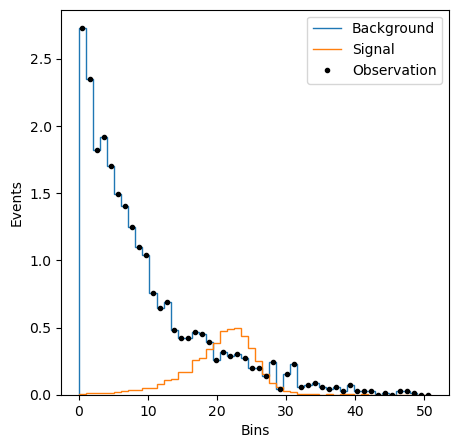

In [114]:
init_pars = model.config.suggested_init()

bkg_pars = init_pars.copy()

bkg_pars[model.config.poi_index] = 0
background = model.expected_actualdata(bkg_pars)
# background = np.append(background, background[-1])

bkg_pars = [0] * len(bkg_pars)
bkg_pars[model.config.poi_index] = 1
signal = model.expected_actualdata(bkg_pars)

data = workspace.data(model, include_auxdata=False)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
plt.stairs(background, bins, label='Background')
plt.stairs(signal, bins, label='Signal')
plt.plot(bins[:-1]+0.5, data, 'o', color='black', markersize=3, label='Observation')

ax.legend()
ax.set_xlabel('Bins')
ax.set_ylabel('Events')
plt.show()



In [98]:
bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0

observations = bkg_hist[0].tolist() + model.config.auxdata  # this is a common pattern!

model.logpdf(pars=bkg_pars, data=observations)

array([-56.86960709])

In [59]:
model.logpdf(pars=init_pars, data=observations)

array([-58.4169025])

In [60]:
pyhf.infer.mle.fit(data=observations, pdf=model)

array([0.        , 1.00000645, 1.00000268, 0.99999669, 1.00000167,
       1.00000737, 1.00000585, 0.99999791, 0.99999965, 0.99999898,
       1.00002566, 0.99986127, 0.99979296, 1.00023055, 0.99985761,
       1.00011745, 1.00011462, 0.99996265, 1.00008957, 1.00011268,
       0.99995453, 0.99997943, 0.99995747, 0.99996816, 0.99995499,
       0.99989715, 0.99992412, 1.00021893, 0.99999191, 0.99964929,
       0.99996545, 0.99999796, 1.00037384, 1.00032184, 1.00005041,
       1.00004511, 0.99998138, 1.        , 0.99938051, 1.00012367,
       0.99978494, 0.99957841, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [66]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
    observations,
    model,
    test_stat="q",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

qmu test statistic used for fit configuration with POI bounded at zero.
Use the qmu_tilde test statistic (pyhf.infer.test_statistics.qmu_tilde) instead.
qmu test statistic used for fit configuration with POI bounded at zero.
Use the qmu_tilde test statistic (pyhf.infer.test_statistics.qmu_tilde) instead.


      Observed CLs: 0.1217
Expected CLs(-2 σ): 0.0085
Expected CLs(-1 σ): 0.0342
Expected CLs( 0 σ): 0.1217
Expected CLs( 1 σ): 0.3470
Expected CLs( 2 σ): 0.6901


In [90]:
poi_values = np.linspace(0.1, 5, 50)
observations = workspace.data(model, include_auxdata=True)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    observations, model, poi_values, level=0.05, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

Upper limit (obs): μ = 1.3204
Upper limit (exp): μ = 1.3204


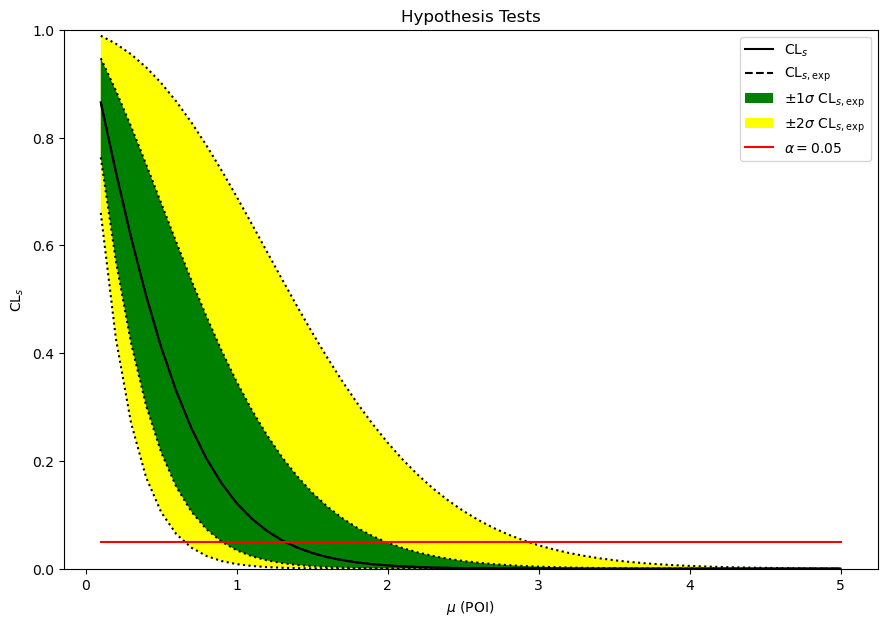

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)

In [ ]:
for name, hist in sig_hists.items():
    print(name)
    with uproot.recreate(path + f'/histograms{name}.root') as f:
        print(type(sig_hists[f"{X}_{S}"]))
        f["SR/Signal/Nominal"] = hist
        f["SR/Background/Nominal"] = hist
        f["SR/Data/Nominal"] = (hist[0] * 2, hist[1])
        
        cabinetry_config = cabinetry.configuration.load("config_ntuples.yml")
        cabinetry.configuration.print_overview(cabinetry_config)

    break

In [ ]:
3000_2000

In [ ]:
cabinetry.set_logging()

In [ ]:
name = '3000_2000'
hist = sig_hists[name]
with uproot.recreate(outDir + f'/histograms{name}.root') as f:
    f["SR/Signal/Nominal"] = hist
    f["SR/Background/Nominal"] = hist
    f["SR/Data/Nominal"] = (hist[0] * 2.1, hist[1])

cabinetry_config = cabinetry.configuration.load("config.yml")
cabinetry.configuration.print_overview(cabinetry_config)

In [ ]:
cabinetry_config["General"]

In [ ]:
cabinetry.templates.collect(cabinetry_config, method="uproot")

In [ ]:
cabinetry.templates.postprocess(cabinetry_config)

In [ ]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

In [ ]:
ws = cabinetry.workspace.load(workspace_path)
model, data = cabinetry.model_utils.model_and_data(ws)
cabinetry.visualize.modifier_grid(model)

In [ ]:
fit_results = cabinetry.fit.fit(model, data)

In [ ]:
cabinetry.visualize.pulls(fit_results, exclude=["Signal_norm"])

In [ ]:
cabinetry.visualize.correlation_matrix(fit_results)

In [ ]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

In [ ]:
_ = cabinetry.tabulate.yields(model_pred, data)

In [ ]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=cabinetry_config)

In [ ]:
with uproot.recreate(out_file) as f:
    sigmc_dfs, sigmc_hists = get_signal_hists(signalDir)
    f["SR/Signal/Nominal"] = sigmc_hists


In [ ]:
run(outDir)

In [ ]:
sigmc_dfs, sigmc_hists = get_signal_hists(signalDir)

In [ ]:
sigmc_dfs

In [ ]:
sigmc_hists["2000_1000"].show()

In [ ]:
columns_to_load = [
    "n_gen_events",
    "HLT_j390_a10t_lcw_jes_30smcINF_L1J100",
    "X_mass",
    "S_mass",
    "H_mass",
    "btag_77",
    "xbbtag_70"
]

truth_X = []
truth_S = []

dfs = {}
sig_hists = {}

filenames = glob.glob(signalDir + '/mc20e*.root') # list   
for filename in filenames:
    df = None 
    f = uproot.open(filename)
    df_yr = f["tree"].arrays(columns_to_load, library="pd")
    # print(df_yr["mc_sf"])

    # apply analysis cuts
    # df_yr["X_SH"] = np.sqrt(((df_yr["m_H"] - 125) / (.1 * df_yr["m_H"])) ** 2 + ((df_yr["m_S"] - ms) / (.1 * df_yr["m_S"])) ** 2)
    btag_mask = (df_yr['btag_77'] == True)
    xbbtag_mask = (df_yr['xbbtag_70'] == True)
    trigger_mask = (df_yr['HLT_j390_a10t_lcw_jes_30smcINF_L1J100'] == True)

    df_yr = df_yr.loc[btag_mask&xbbtag_mask&trigger_mask]

    if df is None:
        df = df_yr
    else:
        df = pd.concat([df, df_yr], ignore_index=True)

    X = int(filename.split('mX')[1].split('_mS')[0])
    S = int(filename.split('mS')[1].split('.root')[0])
    
    truth_X.append(X)
    truth_S.append(S)

    dfs[f"{X}_{S}"] = df
    # bins = np.linspace(250,8000,100)
    bins = np.linspace(1000,3500,10)
    sig_hists[f"{X}_{S}"] = np.histogram(df["X_mass"], bins=bins, weights=1/df["n_gen_events"])
    # sig_hists[f"{X}_{S}"] = np.histogram(df["X_mass"], bins=bins, weights=1)[0]

    # print(f"{X}_{S}")
    # plt.hist(df["X_mass"], bins=bins, weights=1/df["n_gen_events"])[0]
    # plt.show()

    
# Remove duplicates
truth_X = list(set(truth_X))
truth_S = list(set(truth_S))

# Sort in ascending order
truth_X.sort()
truth_S.sort()

print(truth_X)
print(truth_S)